In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Road Detection" "/content/Dataset"

Mounted at /gdrive


In [2]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 7.7 MB/s eta 0:00:00


In [28]:
import os
import numpy as np
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import normalize
from sklearn.utils import class_weight
from keras.metrics import MeanIoU
import imageio
from PIL import Image
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm

%matplotlib inline

In [29]:
path = '/content/Dataset/'
image_path = os.path.join(path, 'OriginalFrames/')
mask_path = os.path.join(path, 'ColoredMasks/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [5]:
image_list = sorted(image_list)
mask_list = sorted(mask_list)

In [6]:
len(image_list)

701

In [7]:
len(mask_list)

701

Text(0.5, 1.0, 'Segmentation')

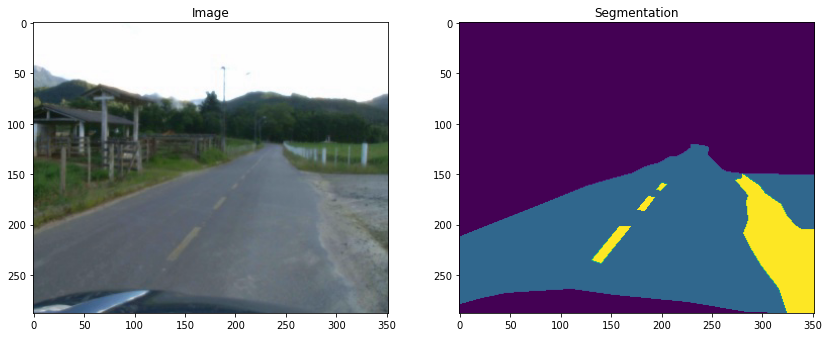

In [8]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [9]:
images = []
for i in range(len(image_list)):
    img = Image.open(image_list[i])
    img = img.resize((256, 256))
    img = asarray(img)
    images.append(img)

In [10]:
masks = []
for i in range(len(mask_list)):
    mask = Image.open(mask_list[i])
    mask = mask.resize((256, 256))
    mask = asarray(mask)
    masks.append(mask)

In [11]:
images = np.array(images)
masks = np.array(masks)

(701, 256, 256, 3)


Text(0.5, 1.0, 'Segmentation')

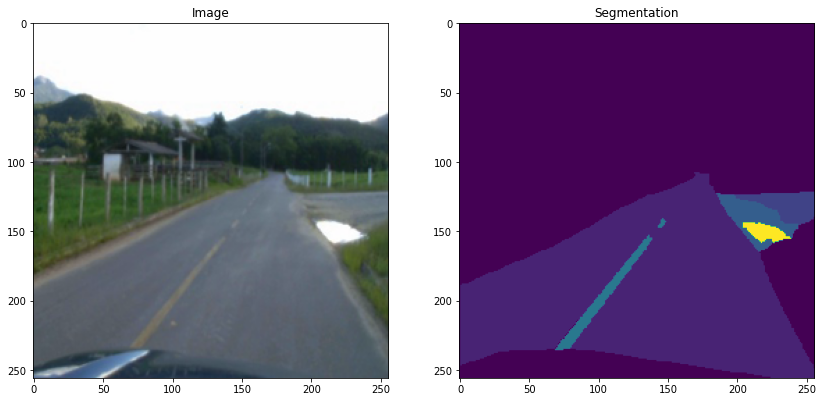

In [12]:
image = images[0]
mask = masks[0]
print(images.shape)
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(image)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')

In [13]:
def mask_to_categorical(masks, n_classes):
  print(np.unique(masks))
  masks_cat = to_categorical(masks, num_classes = n_classes)
  print(masks_cat.shape)
  print(np.unique(masks_cat))
  return masks_cat

In [14]:
masks_cat = mask_to_categorical(masks, 13)

[ 0  1  2  3  4  5  6  7  9 10 11 12]
(701, 256, 256, 13)
[0. 1.]


In [15]:
def get_class_weights(y):
  classes = y.reshape(-1)
  class_weights = class_weight.compute_class_weight(class_weight = "balanced", 
                                                    classes = np.unique(classes),
                                                    y = classes)
  print(class_weights.shape)
  return class_weights

In [16]:
class_weights = get_class_weights(masks)

(12,)


In [17]:
class_weights

array([1.26548315e-01, 6.45881155e-01, 7.93062263e-01, 9.03942338e-01,
       1.06346660e+01, 1.43838092e+02, 4.59425737e+02, 4.88627271e+02,
       3.72629421e+01, 3.05392044e+02, 1.32264456e+02, 2.52984865e+01])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(images, masks_cat, test_size=0.2)

# Model Training

In [19]:
n_classes=13
activation='softmax'

LR = 0.0001
optim = keras.optimizers.Adam(LR)

class_weights = list(class_weights)
print(len(class_weights))
# dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)
total_loss = focal_loss

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

12


### BackBone Models

### Resnet 34

In [20]:
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

In [21]:
X_train1 = preprocess_input1(X_train)
X_test1 = preprocess_input1(X_test)

In [22]:
model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_classes, activation=activation)

85521592/85521592 [==============================] - 6s 0us/step


In [23]:
model1.compile(optim, total_loss, metrics=metrics)

In [24]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [25]:
history1= model1.fit(X_train1, 
          y_train,
          batch_size=8, 
          epochs=100,
          verbose=1,
          validation_data=(X_test1, y_test))

Epoch 1/100
70/70 [==============================] - 31s 216ms/step - loss: 0.0290 - iou_score: 0.1893 - f1-score: 0.1895 - val_loss: 0.0204 - val_iou_score: 0.2293 - val_f1-score: 0.2423
Epoch 2/100
70/70 [==============================] - 13s 181ms/step - loss: 0.0123 - iou_score: 0.3578 - f1-score: 0.3628 - val_loss: 0.0141 - val_iou_score: 0.2995 - val_f1-score: 0.3122
Epoch 3/100
70/70 [==============================] - 13s 182ms/step - loss: 0.0070 - iou_score: 0.4070 - f1-score: 0.4217 - val_loss: 0.0090 - val_iou_score: 0.3343 - val_f1-score: 0.3471
Epoch 4/100
70/70 [==============================] - 13s 180ms/step - loss: 0.0044 - iou_score: 0.5005 - f1-score: 0.5241 - val_loss: 0.0060 - val_iou_score: 0.3637 - val_f1-score: 0.3725
Epoch 5/100
70/70 [==============================] - 13s 180ms/step - loss: 0.0034 - iou_score: 0.5719 - f1-score: 0.5950 - val_loss: 0.0042 - val_iou_score: 0.5021 - val_f1-score: 0.5320
Epoch 6/100
70/70 [==============================] - 13s 182

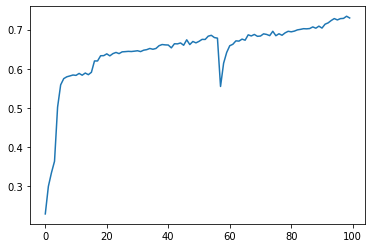

In [26]:
plt.plot(history1.history["val_iou_score"])

In [27]:
model1.save('resnetUnet.hdf5')

### Inception V3

In [ ]:
BACKBONE2 = 'inceptionv3'
preprocess_input2 = sm.get_preprocessing(BACKBONE2)

In [ ]:
X_train2 = preprocess_input2(X_train)
X_test2 = preprocess_input2(X_test)

In [ ]:
model2 = sm.Unet(BACKBONE2, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [ ]:
model2.compile(optim, total_loss, metrics)

In [ ]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [ ]:
history2=model2.fit(X_train2, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(X_test2, y_test))

Epoch 1/20
70/70 [==============================] - 43s 327ms/step - loss: 0.0315 - iou_score: 0.2841 - f1-score: 0.3023 - val_loss: 0.0315 - val_iou_score: 0.4312 - val_f1-score: 0.4609
Epoch 2/20
70/70 [==============================] - 17s 237ms/step - loss: 0.0172 - iou_score: 0.4717 - f1-score: 0.4987 - val_loss: 0.0159 - val_iou_score: 0.5011 - val_f1-score: 0.5222
Epoch 3/20
70/70 [==============================] - 17s 236ms/step - loss: 0.0107 - iou_score: 0.5116 - f1-score: 0.5323 - val_loss: 0.0089 - val_iou_score: 0.4942 - val_f1-score: 0.5166
Epoch 4/20
70/70 [==============================] - 16s 235ms/step - loss: 0.0064 - iou_score: 0.5159 - f1-score: 0.5375 - val_loss: 0.0056 - val_iou_score: 0.5011 - val_f1-score: 0.5260
Epoch 5/20
70/70 [==============================] - 16s 236ms/step - loss: 0.0042 - iou_score: 0.5716 - f1-score: 0.5970 - val_loss: 0.0039 - val_iou_score: 0.5839 - val_f1-score: 0.6047
Epoch 6/20
70/70 [==============================] - 16s 235ms/ste

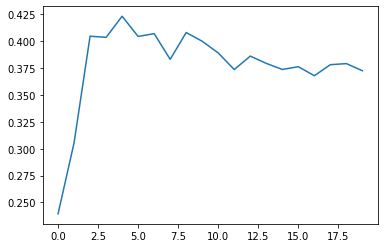

In [ ]:
plt.plot(history2.history["val_iou_score"])

### VGG 16

In [ ]:
BACKBONE3 = 'vgg16'
preprocess_input3 = sm.get_preprocessing(BACKBONE3)

In [ ]:
X_train3 = preprocess_input3(X_train)
X_test3 = preprocess_input3(X_test)

In [ ]:
model3 = sm.Unet(BACKBONE3, encoder_weights='imagenet', classes=n_classes, activation=activation)

In [ ]:
model3.compile(optim, total_loss, metrics)

In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 block1_conv2 (Conv2D)          (None, None, None,   36928       ['block1_conv1[0][0]']           
                                64)                                                           

In [ ]:
history3=model3.fit(X_train3, 
          y_train,
          batch_size=8, 
          epochs=20,
          verbose=1,
          validation_data=(X_test3, y_test))

Epoch 1/20
70/70 [==============================] - 43s 389ms/step - loss: 0.0216 - iou_score: 0.1834 - f1-score: 0.1921 - val_loss: 0.0226 - val_iou_score: 0.3483 - val_f1-score: 0.3537
Epoch 2/20
70/70 [==============================] - 21s 300ms/step - loss: 0.0110 - iou_score: 0.3785 - f1-score: 0.3922 - val_loss: 0.0139 - val_iou_score: 0.3999 - val_f1-score: 0.4088
Epoch 3/20
70/70 [==============================] - 21s 295ms/step - loss: 0.0076 - iou_score: 0.4160 - f1-score: 0.4390 - val_loss: 0.0085 - val_iou_score: 0.4668 - val_f1-score: 0.4907
Epoch 4/20
70/70 [==============================] - 22s 309ms/step - loss: 0.0062 - iou_score: 0.4515 - f1-score: 0.4832 - val_loss: 0.0069 - val_iou_score: 0.5059 - val_f1-score: 0.5379
Epoch 5/20
70/70 [==============================] - 22s 311ms/step - loss: 0.0055 - iou_score: 0.4717 - f1-score: 0.5067 - val_loss: 0.0060 - val_iou_score: 0.5253 - val_f1-score: 0.5600
Epoch 6/20
70/70 [==============================] - 22s 309ms/ste

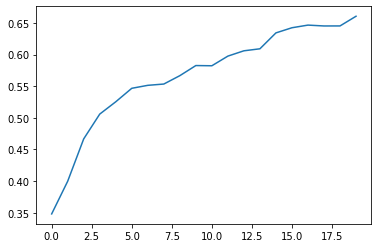

In [ ]:
plt.plot(history3.history["val_iou_score"])